In [1]:
!pip install geopandas matplotlib shapely cdsapi numpy xarray rioxarray netcdf4 scipy pandas catboost scikit-learn

In [2]:
import geopandas as gpd
import ast
import shapely
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import catboost

In [3]:
def convert_gee_geo(row):
    le = ast.literal_eval(row['.geo'])
    return shapely.Polygon(le['coordinates'][0])

def read_gsw_file(loc):
    df = gpd.read_file(loc)
    df.columns = ['system:index',
     'COAST',
     'DIST_MAIN',
     'DIST_SINK',
     'ENDO',
     'HYBAS_ID',
     'MAIN_BAS',
     'NEXT_DOWN',
     'NEXT_SINK',
     'ORDER',
     'PFAF_ID',
     'SORT',
     'SUB_AREA',
     'UP_AREA',
     'water_balance',
     '.geo',
     'geometry']
    df['SUB_AREA'] = df.SUB_AREA.apply(float)
    df['.geo'] = df.apply(convert_gee_geo, axis=1)
    df.set_geometry('.geo', inplace=True)
    df.set_crs("EPSG:4326", inplace=True)
    df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA

    return df

In [4]:
# df = gpd.read_file('data/diff_hb_2010.csv')
# # df.set_geometry('.geo', inplace=True)
# df.columns = ['system:index',
#  'COAST',
#  'DIST_MAIN',
#  'DIST_SINK',
#  'ENDO',
#  'HYBAS_ID',
#  'MAIN_BAS',
#  'NEXT_DOWN',
#  'NEXT_SINK',
#  'ORDER',
#  'PFAF_ID',
#  'SORT',
#  'SUB_AREA',
#  'UP_AREA',
#  'water_balance',
#  '.geo',
#  'geometry']
# df['SUB_AREA'] = df.SUB_AREA.apply(float)

# def convert_gee_geo(row):
#     le = ast.literal_eval(row['.geo'])
#     return shapely.Polygon(le['coordinates'][0])

# df['.geo'] = df.apply(convert_gee_geo, axis=1)
# df.set_geometry('.geo', inplace=True)
# df.set_crs("EPSG:4326", inplace=True)
# ''
df = read_gsw_file(loc='data/diff_hb_2010.csv')

In [5]:
# df.crs

In [6]:
# df.head()

In [7]:
# df['water_balance'] = df.water_balance.astype(float) * df.SUB_AREA # 30m by 30m pixels / 

<Axes: >

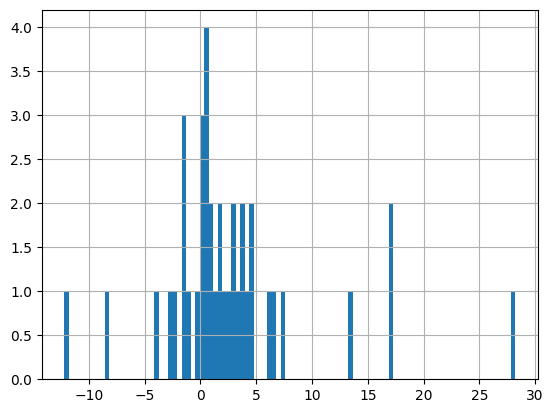

In [8]:
df.water_balance.hist(bins=100)

<Axes: >

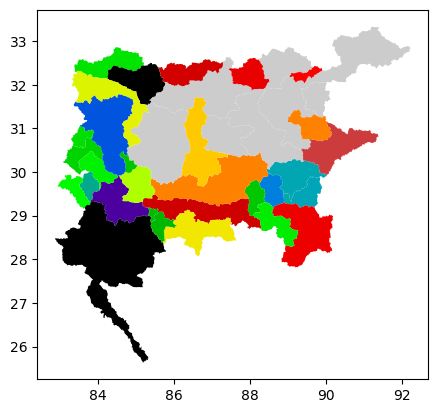

In [9]:
df.plot('water_balance', cmap='nipy_spectral', vmin=-5, vmax=5)


In [10]:
# downloaded = True

# if downloaded == False:

#     import cdsapi

#     c = cdsapi.Client()

#     years = np.arange(2012, 2022, 1)
#     days = [
#                 '01', '02', '03',
#                 '04', '05', '06',
#                 '07', '08', '09',
#                 '10', '11', '12',
#                 '13', '14', '15',
#                 '16', '17', '18',
#                 '19', '20', '21',
#                 '22', '23', '24',
#                 '25', '26', '27',
#                 '28', '29', '30',
#                 '31',
#             ]
#     months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#     times = '23:00'
#     area = [45, 68, 24, 107]

#     for year in years:
#         year = str(year)
#         c.retrieve('reanalysis-era5-land', {'year':year, 'month':months, 'time':times, 'day':days, 'area':area
#                                            ,'variable':'total_precipitation', 'format':'netcdf.zip'}
#                   ,'precip-'+year+'netcdf.zip')

# # now we need to unzip the data
# if downloaded == False:
#     import glob
#     import shutil
#     for f in glob.glob('data/precip/*'):
#         unzipped_filename = f.split('-')[1][0:4]
#         shutil.unpack_archive(f, unzipped_filename)

In [17]:
def read_precip_data(year):
    precip = xr.open_dataset(f'data/precip/{year}data.nc')
    # precip_plusone = xr.open_dataset(f'data/precip/{year}data.nc')
    # precips = xr.concat([precip, precip_plusone], dim=['longitude', 'latitude'])
    # return precips
    return precip

def read_temp_data(year):
    temp = xr.open_dataset(f'data/temp/temp{year}.nc')
    # temp_plus
    return temp

def read_glacier_data(year):
    glac = xr.open_dataset(f'data/glacier/{year}glaciers.nc4')
    return glac

# def get_mean_std(gsw, precip):
# def get_mean_std(gsw, var, name):
def get_stats(gsw, var, name):
    
    var = var.rio.write_crs(gsw.crs)

    means = []
    stdev = []
    maxes = []
    mines = []

    for poly in gsw['.geo'].values:
        
        try:
            mean = var.rio.clip([poly], gsw.crs)[f'{name}'].mean().item()
            std = var.rio.clip([poly], gsw.crs)[f'{name}'].std().item()
            max = var.rio.clip([poly], gsw.crs)[f'{name}'].max().item()
            min = var.rio.clip([poly], gsw.crs)[f'{name}'].min().item()
            
        except:
            mean = 0
            std = 0
            max = 0
            min = 0

        means.append(mean)
        stdev.append(std)
        maxes.append(max)
        mines.append(min)
    
    gsw[f'{name}_means'] = means
    gsw[f'{name}_stdev'] = stdev
    gsw[f'{name}_max'] = maxes
    gsw[f'{name}_min'] = mines
    
    return gsw

def pipeline(year):
    gsw_data = read_gsw_file(loc=f'data/diff_hb_{year}.csv')
    precip = read_precip_data(year=year)
    temp = read_temp_data(year=year)
    glac = read_glacier_data(year=year)
    gsw_data = get_stats(gsw=gsw_data, var=precip, name='tp')
    gsw_data = get_stats(gsw=gsw_data, var=temp, name='t2m')
    glac = get_stats(gsw=gsw_data, var=glac, name='Glacier')
    gsw_data['year'] = year
    return gsw_data

In [18]:
!pip install multiprocess

In [19]:
# from multiprocessing import Pool
import multiprocess as mp
pool = mp.Pool(8)

years = np.arange(2000, 2012, 1)
dfs = pool.map(pipeline, years)
pool.close()

/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mnky9800n/anaconda3/envs/tblakes/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for

In [20]:
df = pd.concat(dfs)

In [21]:
df.head()

,system:index,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,tp_min,t2m_means,t2m_stdev,t2m_max,t2m_min,Glacier_means,Glacier_stdev,Glacier_max,Glacier_min,year
0,000000000000000017e6,0,2331.1,2331.1,0,4060788280,4060025450,4060786650,4060025450,1,...,0.0,268.490387,7.953619,283.411682,242.441971,-0.005459,0.005426,-0.000033,-0.010885,2000
1,000000000000000017e7,0,2413.2,2413.2,0,4060787190,4060025450,4060788280,4060025450,1,...,0.0,271.436371,6.909279,284.207489,252.633331,0.000000,0.000000,0.000000,0.000000,2000
2,000000000000000017e8,0,2439.8,2439.8,0,4060787530,4060025450,4060787190,4060025450,1,...,0.0,268.294098,6.948942,283.875916,248.422302,-0.015403,0.000000,-0.015403,-0.015403,2000
3,000000000000000017e9,0,2497.1,2497.1,0,4060787180,4060025450,4060787530,4060025450,1,...,0.0,268.866699,7.088486,283.084106,247.529694,0.000000,0.000000,0.000000,0.000000,2000
4,000000000000000017ea,0,2554.1,2554.1,0,4060785160,4060025450,4060787180,4060025450,1,...,0.0,266.136688,8.336726,281.716675,236.063736,-0.005050,0.003893,-0.001100,-0.009603,2000


In [22]:
# # years = np.arange(2000, 2022, 1)
# years = np.arange(2000, 2012, 1)
# dfs = []
# for year in years:
#     gsw_data = read_gsw_file(loc=f'data/diff_hb_{year}.csv')
#     precip = read_precip_data(year=year)
#     temp = read_temp_data(year=year)
#     # gsw_data = get_mean_std(gsw=gsw_data, precip=precip)
#     gsw_data = get_stats(gsw=gsw_data, var=precip, name='tp')
#     gsw_data = get_stats(gsw=gsw_data, var=temp, name='t2m')
#     gsw_data['year'] = year
#     dfs.append(gsw_data)

In [23]:
df = pd.concat(dfs)

In [34]:
cols = df.columns
dont_keep = ['system:index'
             , 'HYBAS_ID'
             , 'MAIN_BAS'
             , 'NEXT_DOWN'
             , 'NEXT_SINK'
             , 'ORDER'
             , 'PFAF_ID'
             , 'SORT'
             ,'.geo'
             , 'geometry']
cols = np.setdiff1d(cols, dont_keep)
cols

array(['COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 'Glacier_max',
       'Glacier_means', 'Glacier_min', 'Glacier_stdev', 'SUB_AREA',
       'UP_AREA', 't2m_max', 't2m_means', 't2m_min', 't2m_stdev',
       'tp_max', 'tp_means', 'tp_min', 'tp_stdev', 'water_balance',
       'year'], dtype=object)

In [25]:
# fig, ax = plt.subplots()

# df.plot.scatter('precip_means', 'water_balance', c='year', ax=ax)
# # ax.set_xlim(0, 0.004)
# # ax.set_ylim(-50, 50)

In [25]:
# df.columns
# cb_columns = [ 'ENDO', 'SUB_AREA', 'water_balance', 
#        'tp_means', 'tp_stdev', 'tp_max', 'tp_min', 't2m_means', 't2m_stdev', 't2m_max',
#        't2m_min', 'year']

In [26]:
# df['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011])

In [27]:
# df.columns

Index(['system:index', 'COAST', 'DIST_MAIN', 'DIST_SINK', 'ENDO', 'HYBAS_ID',
       'MAIN_BAS', 'NEXT_DOWN', 'NEXT_SINK', 'ORDER', 'PFAF_ID', 'SORT',
       'SUB_AREA', 'UP_AREA', 'water_balance', '.geo', 'geometry', 'tp_means',
       'tp_stdev', 'tp_max', 'tp_min', 't2m_means', 't2m_stdev', 't2m_max',
       't2m_min', 'year'],
      dtype='object')

In [35]:
# import pandas as pd
from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# cols = [ 'ENDO', 'SUB_AREA', 'water_balance', 
#        'tp_means', 'tp_stdev', 'tp_max', 'tp_min', 't2m_means', 't2m_stdev', 't2m_max',
#        't2m_min', 'year']
# Assuming 'df' is your DataFrame
# Prepare your features and target variables
X = df[cols]
y = df['water_balance']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = df[df['year']<=2007]
test = df[df['year']>2007]

X_train = train[cols]
y_train = train['water_balance']

X_test = test[cols]
y_test = test['water_balance']

# Initialize CatBoost Regressor
# Specify the categorical features; they are assumed to be of object type
# categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
model = CatBoostRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict(X_test)
rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
r2_score = metrics.r2_score(y_test, predictions)
print(f'RMSE: {rmse}')


Learning rate set to 0.034061
0:	learn: 22.8965946	total: 60.2ms	remaining: 1m
1:	learn: 22.6019543	total: 61.3ms	remaining: 30.6s
2:	learn: 22.3369104	total: 63.1ms	remaining: 21s
3:	learn: 22.0751533	total: 64.1ms	remaining: 16s
4:	learn: 21.7684339	total: 65.1ms	remaining: 13s
5:	learn: 21.5647655	total: 66.2ms	remaining: 11s
6:	learn: 21.3917477	total: 67.9ms	remaining: 9.63s
7:	learn: 21.2648574	total: 68.9ms	remaining: 8.54s
8:	learn: 20.9994641	total: 70.1ms	remaining: 7.71s
9:	learn: 20.7365161	total: 71.1ms	remaining: 7.04s
10:	learn: 20.6200853	total: 72.1ms	remaining: 6.48s
11:	learn: 20.3971447	total: 73ms	remaining: 6.01s
12:	learn: 20.1328059	total: 74ms	remaining: 5.62s
13:	learn: 19.8929611	total: 74.6ms	remaining: 5.25s
14:	learn: 19.6540490	total: 76.3ms	remaining: 5.01s
15:	learn: 19.4025004	total: 77.2ms	remaining: 4.75s
16:	learn: 19.1706343	total: 78.2ms	remaining: 4.52s
17:	learn: 19.0330576	total: 79.2ms	remaining: 4.32s
18:	learn: 18.9000370	total: 80ms	remaini

In [36]:
print(f'RMSE (precipitation): {rmse}')
print(f'R2   (precipitation): {r2_score}')

RMSE (precipitation): 10.902739387227822
R2   (precipitation): 0.6888898348027093


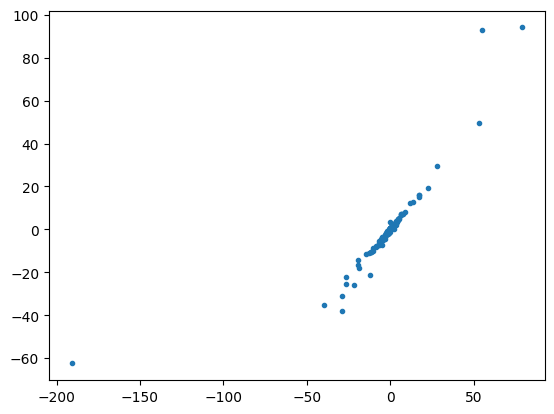

In [41]:
fig, ax = plt.subplots()

ax.scatter(y_test, predictions, marker='.')
# ax.set_yscale('log')